# Multinomial Naive Bayes

We want to perform a text classification task based on the SMS Spam collection dataset `doi: 10.24432/C5CC84`.

The following Code blocks will provide a tutorial for text based classification if a mail is spam or not.

We will focus on Multinomial Naive Bayes Classificator, because the gaussian algorithm is very similar to logistic regression.

# Loading the modules

In [80]:
# 1. Import modules

## Building model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

## Metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

## Bayes model 
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/erikdechant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/erikdechant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/erikdechant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/erikdechant/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Loading the data 

Mail dataset will be loaded first. 
The dataset is a .txt tab seperated.

In [81]:
# Define path 
mail_df_path = "/Users/erikdechant/Desktop/UNI/Master_of_synthetic_biotechnology/APLM/PL/PL_Video/sms+spam+collection/SMSSpamCollection"

# Read file as csv
mail_df = pd.read_csv(mail_df_path, sep="\t", header=None, names=["Label", "Message"]) # Give the tab sep file column names
print(f"Datashape{mail_df.shape}")
mail_df.head(10)  

Datashape(5572, 2)


,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


# Cleaning Data

Now we need to preprocess the dataset. The steps will include:
- Designing column names for the dataframe including a new column target, which is basicly OneHotEncoded Label names
- Visualizing the data
- Look for duplicate messages and delete them if nessecairy
- Look for missing values and delete them if necessairy


In [82]:
# Add a new column "target" classifying ham = 0 and spam = 1
mail_df['target'] = np.where(mail_df['Label']=='ham',0, 1)
print(f"Datashape{mail_df.shape}")
mail_df.head(10)

Datashape(5572, 3)


,Label,Message,target
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
6,ham,Even my brother is not like to speak with me. ...,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1


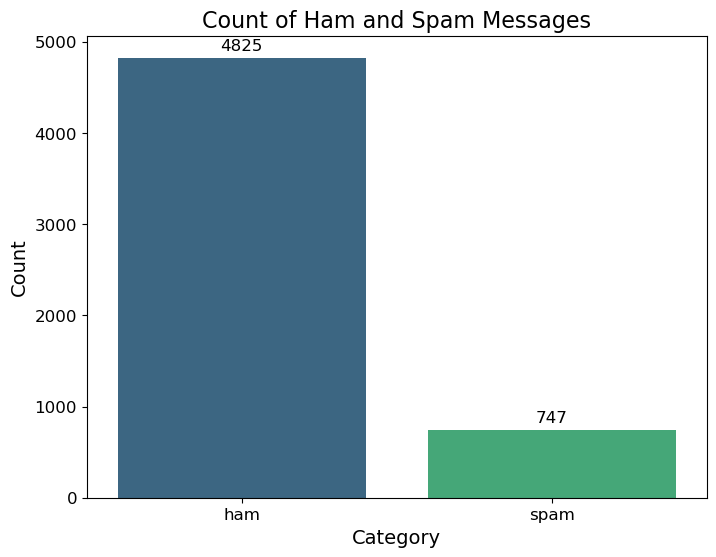

In [83]:
# Visualize the data
# Create a bar plot 
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Label', data=mail_df, palette='viridis')

# Add the counts above the bars
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., count),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Customize the plot
plt.title('Count of Ham and Spam Messages', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Duplicate Messages:
     Label                                            Message  target
103    ham  As per your request 'Melle Melle (Oru Minnamin...       0
154    ham  As per your request 'Melle Melle (Oru Minnamin...       0
207    ham  As I entered my cabin my PA said, '' Happy B'd...       0
223    ham                             Sorry, I'll call later       0
326    ham                   No calls..messages..missed calls       0
...    ...                                                ...     ...
5524  spam  You are awarded a SiPix Digital Camera! call 0...       1
5535   ham  I know you are thinkin malaria. But relax, chi...       0
5539   ham                         Just sleeping..and surfing       0
5553   ham                        Hahaha..use your brain dear       0
5558   ham                             Sorry, I'll call later       0

[403 rows x 3 columns]
Total number of duplicate messages: 403


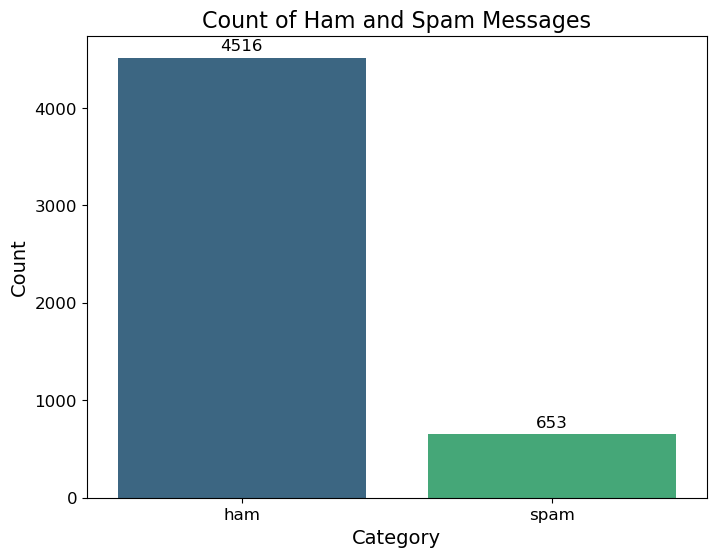

In [84]:
# Clean data
# Find duplicate messages
duplicates = mail_df[mail_df['Message'].duplicated()]

# Display duplicate rows
print("Duplicate Messages:")
print(duplicates)

# Count the number of duplicates
duplicate_count = mail_df['Message'].duplicated().sum()
print(f"Total number of duplicate messages: {duplicate_count}")

# Remove duplicates and keep first occurance of message
mail_df_unique = mail_df.drop_duplicates(subset='Message', keep='first')

# Create a bar plot 
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Label', data=mail_df_unique , palette='viridis')

# Add the counts above the bars
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., count),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Customize the plot
plt.title('Count of Ham and Spam Messages', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [85]:
# Check for missing values in dataset
print(f"Missing data in each column:\n {mail_df_unique.isnull().sum()}")

Missing data in each column:
 Label      0
Message    0
target     0
dtype: int64


# Split data

In [86]:
# Do the train test split
X_train, X_test, Y_train, Y_test = train_test_split(mail_df_unique['Message'], mail_df_unique['target'], test_size=0.3, random_state=42)

# Visualize the data split
print(f"X_train:{X_train.head()} \n X_test: {X_test.head()} \n Y_train:{Y_train.head()} \n Y_test {Y_test.head()}")

X_train:1757    Lmao ok I wont be needing u to do my hair anym...
1048    1000's flirting NOW! Txt GIRL or BLOKE & ur NA...
4916    We took hooch for a walk toaday and i fell ove...
3113                  Just haven't decided where yet eh ?
2607    R U &SAM P IN EACHOTHER. IF WE MEET WE CAN GO ...
Name: Message, dtype: object 
 X_test: 1617    K, makes sense, btw carlos is being difficult ...
2064    URGENT! Your mobile No *********** WON a £2,00...
1272    If you still havent collected the dough pls le...
3020                   Wat time do u wan 2 meet me later?
3642    You can stop further club tones by replying "S...
Name: Message, dtype: object 
 Y_train:1757    0
1048    1
4916    0
3113    0
2607    0
Name: target, dtype: int64 
 Y_test 1617    0
2064    1
1272    0
3020    0
3642    1
Name: target, dtype: int64


# Preprocess the Data

After cleaning the data and splitting it, the data is now ready for being preprocessed for being used in the naive bayes classifier.

This includes:
- natural language processing tasks (tokenization, stop-word removal, stemming and lemmatization)
- word embedding technique will be used, called bag of words to extract features from the text (This technique calculates the frequency of words within a given document, which can help us classify documents assuming that similar documents have similar content)
- Usage of scikit-learn´s CountVectorizer or TfidfVectorizer to do the heavy lifting for us here. To the purpose of this tutorial I will just quickly show how the different Vectorizers are computed and how they perform when combined. 

In [87]:
# Defining a function for language processing tasks
def text_clean(text, method, rm_stop):
    text = re.sub(r"\n","",text)   #remove line breaks
    text = text.lower() #convert to lowercase
    text = re.sub(r"\d+","",text)   #remove digits  
    text = re.sub(r'[\$\d+\d+\$]', "", text) #remove currencies
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)   #remove dates 
    text = re.sub(r'[^\x00-\x7f]',r' ',text)   #remove non-ascii
    text = re.sub(r'[^\w\s]','',text)   #remove punctuation
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)   #remove hyperlinks

    #remove stop words
    if rm_stop == True:
        filtered_tokens = [word for word in word_tokenize(text) if not word in set(stopwords.words('english'))]
        text = " ".join(filtered_tokens)

    #lemmatization: typically preferred over stemming
    if method == 'L':
        lemmer = WordNetLemmatizer()
        lemm_tokens = [lemmer.lemmatize(word) for word in word_tokenize(text)]
        return " ".join(lemm_tokens)

    #stemming
    if method == 'S':
        porter = PorterStemmer()
        stem_tokens = [porter.stem(word) for word in word_tokenize(text)]
        return " ".join(stem_tokens)

    return text

# preprocess data: Lemm + stopword removal 
preprocessed_text1 = [text_clean(mail_df_unique, 'L', True) for mail_df_unique in X_train]

# preprocess data: Lemm + no stopword removal
preprocessed_text2 = [text_clean(mail_df_unique, 'L', False) for mail_df_unique in X_train]

# preprocess data: Stemm + stopword removal 
preprocessed_text3 = [text_clean(mail_df_unique, 'S', True) for mail_df_unique in X_train]

# preprocess data: Stemm + no stopword removal
preprocessed_text4 = [text_clean(mail_df_unique, 'S', False) for mail_df_unique in X_train]


print(f"Lemm + Stopword removal \n {''.join(preprocessed_text1[:5])}\n")

print(f"Lemm + No Stopword removal \n {''.join(preprocessed_text2[:5])}\n")

print(f"Stemm + Stopword removal \n {''.join(preprocessed_text3[:5])}\n")

print(f"Stemm + No Stopword removal \n {''.join(preprocessed_text4[:5])}\n")



Lemm + Stopword removal 
 lmao ok wont needing u hair anymoreflirting txt girl bloke ur name age eg girl zoe join get chattingtook hooch walk toaday fell splat grazed knee everything stayed home see tomorrowhavent decided yet ehr u sam p eachother meet go house

Lemm + No Stopword removal 
 lmao ok i wont be needing u to do my hair anymores flirting now txt girl or bloke ur name age eg girl zoe to to join and get chattingwe took hooch for a walk toaday and i fell over splat grazed my knee and everything should have stayed at home see you tomorrowjust havent decided where yet ehr u sam p in eachother if we meet we can go my house

Stemm + Stopword removal 
 lmao ok wont need u hair anymorflirt txt girl bloke ur name age eg girl zoe join get chattook hooch walk toaday fell splat graze knee everyth stay home see tomorrowhavent decid yet ehr u sam p eachoth meet go hous

Stemm + No Stopword removal 
 lmao ok i wont be need u to do my hair anymors flirt now txt girl or bloke ur name age eg 

In [67]:
# Tranformation function based on CountVectorizer
def tranform_model_data_w_count_vectorizer(preprocessed_text, Y_train, X_test, Y_test):
    # Vectorize Dataset
    vectorizer = CountVectorizer()
    vectorized_data = vectorizer.fit_transform(preprocessed_text)

    # Define Model
    model = MultinomialNB(alpha=0.1)
    model.fit(vectorized_data, Y_train)

    # Compute model metrics
    predictions = model.predict(vectorizer.transform(X_test))
    accuracy = accuracy_score(Y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions)

    # Disply metrics
    print("Accuracy",round(100*accuracy,2),'%')
    print("balanced_accuracy_score",round(100*balanced_accuracy,2),'%')
    print("precision_score",round(100*precision,2),'%')
    return predictions

# Tranformation function based on tfidfVectorizer
def transform_model_data_w_tfidf_vectorizer(preprocessed_text, Y_train, X_test, Y_test):
    # Vectorize Dataset
    tfidf = TfidfVectorizer()
    vectorized_data = tfidf.fit_transform(preprocessed_text)

    # Define model
    model = MultinomialNB(alpha=0.1)
    model.fit(vectorized_data, Y_train)

    # Evaluate model
    predictions = model.predict(tfidf.transform(X_test))

    # Compute model metrics
    accuracy = accuracy_score(Y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions)

    # Print model metrics
    print("Accuracy",round(100*accuracy,2),'%')
    print("balanced_accuracy_score",round(100*balanced_accuracy,2),'%')
    print("precision_score",round(100*precision,2),'%')
    return predictions


In [68]:
# Use the Pipeline vectorize, model and evaluate model using CountVectorizer and different language preprocessing tasks

# Lem + stoppword removal
print("Lemm + stopword removal + CountVectorizer")
tranform_model_data_w_count_vectorizer(preprocessed_text1, Y_train, X_test, Y_test)

# Lemm + no stopword removal 
print("\nLemm + no stopword removal + CountVectorizer")
tranform_model_data_w_count_vectorizer(preprocessed_text2, Y_train, X_test, Y_test)

# Stem + stopword removal
print("\nStemm + Stopword removal + CountVectorizer")
tranform_model_data_w_count_vectorizer(preprocessed_text3, Y_train, X_test, Y_test)

# Stem + no stopword removal
print("\nStem + no stopword removal + CountVectorizer")
tranform_model_data_w_count_vectorizer(preprocessed_text4, Y_train, X_test, Y_test)

Lemm + stopword removal + CountVectorizer
Accuracy 96.91 %
balanced_accuracy_score 94.52 %
precision_score 86.24 %

Lemm + no stopword removal + CountVectorizer
Accuracy 97.81 %
balanced_accuracy_score 95.45 %
precision_score 91.35 %

Stemm + Stopword removal + CountVectorizer
Accuracy 97.16 %
balanced_accuracy_score 92.4 %
precision_score 92.19 %

Stem + no stopword removal + CountVectorizer
Accuracy 97.61 %
balanced_accuracy_score 93.9 %
precision_score 92.89 %


array([0, 1, 0, ..., 0, 0, 0])

In [69]:
# Use the Pipeline Tfidfvectorizer, model and evaluate model using TfidfVectorizer and different language preprocessing tasks

# Lem + stoppword removal
print("Lemm + stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text1, Y_train, X_test, Y_test)

# Lemm + no stopword removal 
print("\nLemm + no stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text2, Y_train, X_test, Y_test)

# Stem + stopword removal
print("\nStemm + Stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text3, Y_train, X_test, Y_test)

# Stem + no stopword removal
print("\nStem + no stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text4, Y_train, X_test, Y_test)

Lemm + stopword removal + TfidfVectorizer
Accuracy 97.94 %
balanced_accuracy_score 93.47 %
precision_score 96.77 %

Lemm + no stopword removal + TfidfVectorizer
Accuracy 98.07 %
balanced_accuracy_score 93.34 %
precision_score 98.35 %

Stemm + Stopword removal + TfidfVectorizer
Accuracy 96.45 %
balanced_accuracy_score 87.27 %
precision_score 98.09 %

Stem + no stopword removal + TfidfVectorizer
Accuracy 96.97 %
balanced_accuracy_score 88.8 %
precision_score 99.38 %


array([0, 1, 0, ..., 0, 0, 0])

# Quality Control

Now that we made the predictions we will look at the stem + no stopword removal preprocessed dataset metrics. This was decided randomly for purpose of this tutorial.


In [70]:
# Look at metrics from tfidfVectorization and language preprocessing including Stem + no stopword removal
predictions = transform_model_data_w_tfidf_vectorizer(preprocessed_text4, Y_train, X_test, Y_test)

Accuracy 96.97 %
balanced_accuracy_score 88.8 %
precision_score 99.38 %


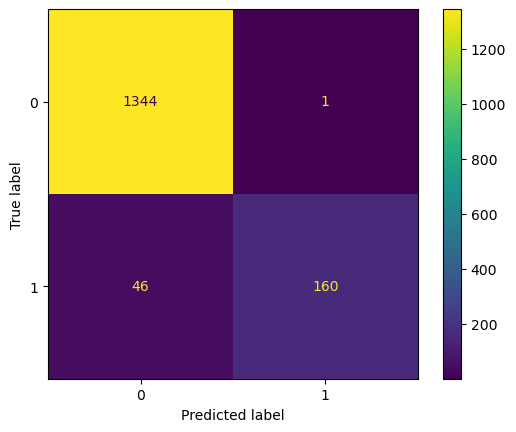

In [71]:
# Confusion matrix
cm = confusion_matrix(Y_test, predictions)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Summary

The Multinomial Naive Bayes model is similarly workig as a OnehotEncoder in logistic regression, doing classifactions as predictions but in contrast just based on the probabilites of words occuring (in this case words occuring in a spam mail like "money").

There are other forms of naive bayes as well, like:
- `Gaussian Naive Bayes` (GNB)
- Bernoulli Naive Bayes

which work for different types of datasets, like integers. Therefore we will review a quick example of the GNB for reasons of clarification and predict, based on several plant measurments, which plant is present according to the data.

In [72]:
# Gaussian Naive Bayes

# import module
from sklearn.naive_bayes import GaussianNB

# Make model
model = GaussianNB()

# Train model
model.fit(X_train, Y_train)
# Just works with numbers and makes classifications based on integers like for example determination of flowers when giving measurment data of different parts of the plant

ValueError: could not convert string to float: 'Lmao ok I wont be needing u to do my hair anymore.'

# GNB for plant classification

In [73]:
# Import modules
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as  pd
import numpy as np
from sklearn.metrics import confusion_matrix
print("Setup Complete")

Setup Complete


# Load Dataset and Preprocess Data

The preprocessing includes:

- Making the iris tuple readable for humans
- splitting the data into X (containing all data nessecairy for classification tasks) and Y (containing the target values class 0-2)
- Splitting the data into Trainnig and Test Data 
- Visualization of the data distribution (to get an idea how the algorithm works)

Iris Dataset Overview:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target target_name  
0       0      setosa  
1       0      setosa  
2       0      setosa  
3       0      setosa  
4       0      setosa  

Iris X[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
Iris Y[0 0 0 0 0]
x_train[[4.6 3.6 1.  0.2]
 [5.7 4.4 1.5 0.4]
 [6.7 3.1 4.4 1.4]
 [4.8 3.4 1.6 0.2]
 [4.4 3.2 1.3 0.2]]
y_train[0 0 1 0 0]

Training Set Size: 120
Testing Set Size: 30


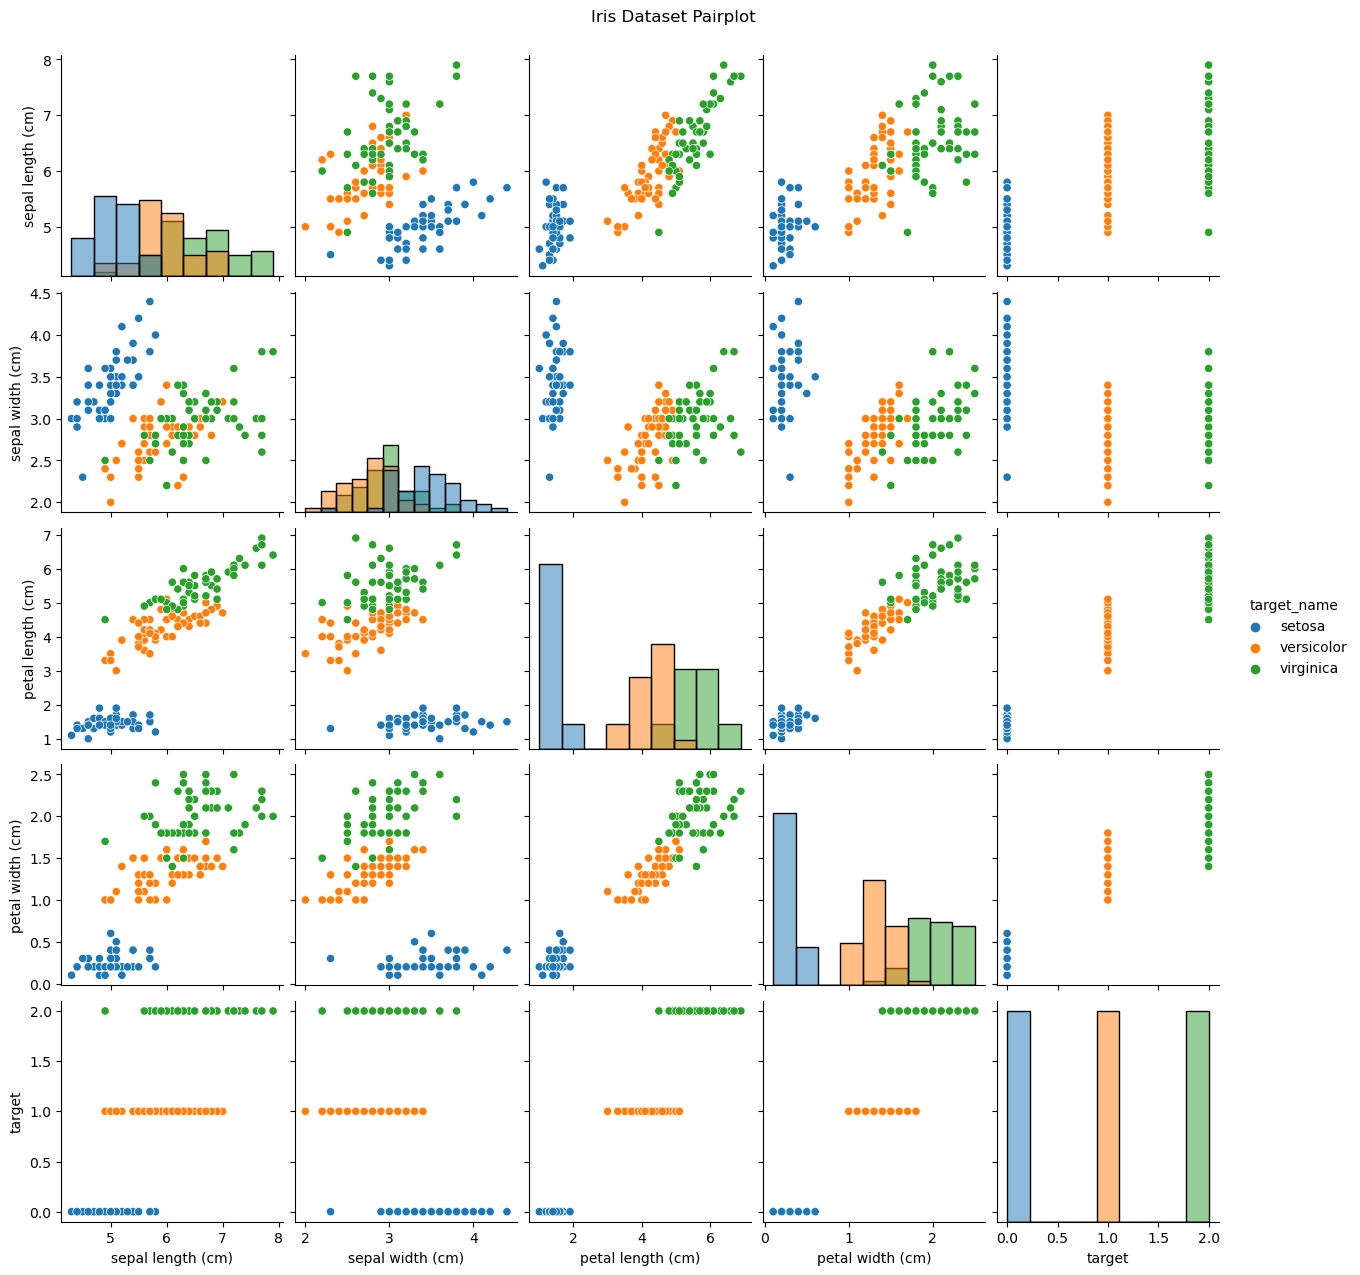

In [74]:
# Load the iris dataset
iris = load_iris()

# Convert the dataset to a Pandas DataFrame for readability
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target
iris_df['target_name'] = iris_df['target'].apply(lambda x: iris.target_names[x])

# Display the first few rows of the dataset
print("Iris Dataset Overview:")
print(iris_df.head())

# Split dataset into train and test sets
X = iris.data
Y = iris.target

# Perfrom the train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"\nIris X{X[:5]}\nIris Y{Y[:5]}\nx_train{x_train[:5]}\ny_train{y_train[:5]}")

# Summary of train and test split
print("\nTraining Set Size:", len(x_train))
print("Testing Set Size:", len(x_test))

# Show the data distribution for explaining Gaussian naive bayes
# Pairplot for the Iris dataset
sns.pairplot(iris_df, hue='target_name', diag_kind='hist')
plt.suptitle("Iris Dataset Pairplot", y=1.02)
plt.show()

# Training the model 

For establishing the GNB model, it is nessecairy to:
- Use StandardScaler for the integer values and to drop the column target_name which is containing the names (strings) of the target classes.

Afterwards the model will be trained and predictions can be made and evaluated

In [75]:
# Fitting the model
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Create and train the Gaussian Naive Bayes model
model = GaussianNB()
model.fit(x_train, y_train)

GaussianNB()

In [76]:
# Predict the classes for the test set
y_pred = model.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("accuracy_score", accuracy)


accuracy_score 1.0


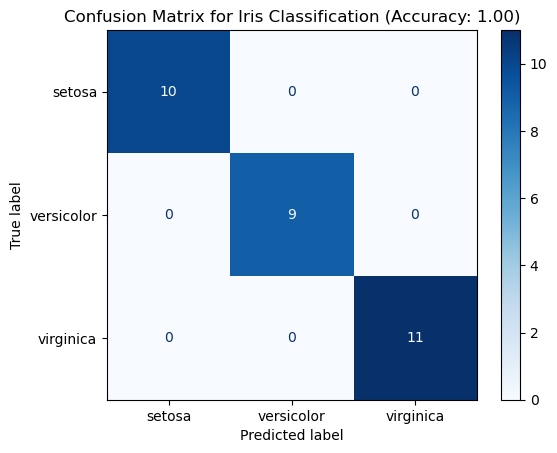

In [77]:
# Generate and display the confusion matrix based on the same `y_pred` and `y_test`
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=iris.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for Iris Classification (Accuracy: {accuracy:.2f})")
plt.show()

# FIN

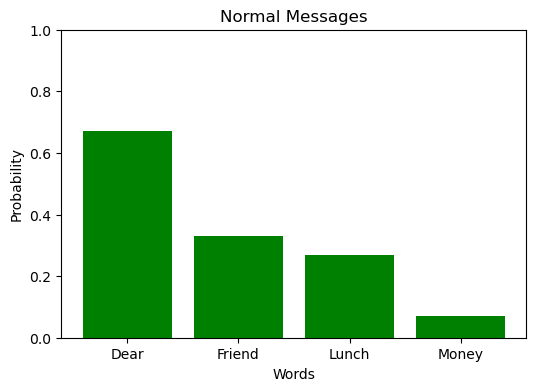

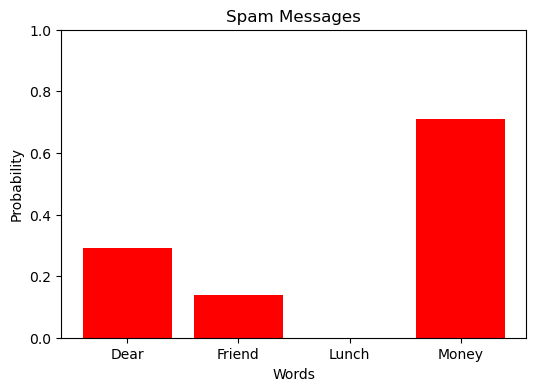

In [3]:
import matplotlib.pyplot as plt

# Data
labels = ['Dear', 'Friend', 'Lunch', 'Money']
normal_values = [0.67, 0.33, 0.27, 0.07]
spam_values = [0.29, 0.14, 0.00, 0.71]

# Normal Messages Plot
plt.figure(figsize=(6, 4))
plt.bar(labels, normal_values, color='green')
plt.title('Normal Messages')
plt.xlabel('Words')
plt.ylabel('Probability')
plt.ylim(0, 1)  # Ensure consistent scale
plt.show()

# Spam Messages Plot
plt.figure(figsize=(6, 4))
plt.bar(labels, spam_values, color='red')
plt.title('Spam Messages')
plt.xlabel('Words')
plt.ylabel('Probability')
plt.ylim(0, 1)  # Ensure consistent scale
plt.show()